### <a href="https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip">Dataset</a>

## Image preprocessing

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import Adam
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # don't use GPU

# not used for now:
# from utils import Vessels, get_model
# from skimage.filters import frangi # run very slow
# tf.config.run_functions_eagerly(True)

In [3]:
img_size = (512,512)

In [73]:
X = []
y = []
z = []

# mask (z) are not used at all at this stage 

images_dir = 'images'
targets_dir = 'manual1'
masks_dir = 'mask'

images = sorted(os.listdir(images_dir))
targets = sorted(os.listdir(targets_dir))
masks = sorted(os.listdir(masks_dir))

for img_dir, target_dir, mask_dir in zip(images, targets, masks):
    img = cv2.imread(os.path.join(images_dir, img_dir))
    img = cv2.resize(img, img_size)
    target = cv2.imread(os.path.join(targets_dir, target_dir), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, img_size)
    mask = cv2.imread(os.path.join(masks_dir, mask_dir), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    X.append(img)
    y.append(target)
    z.append(mask)

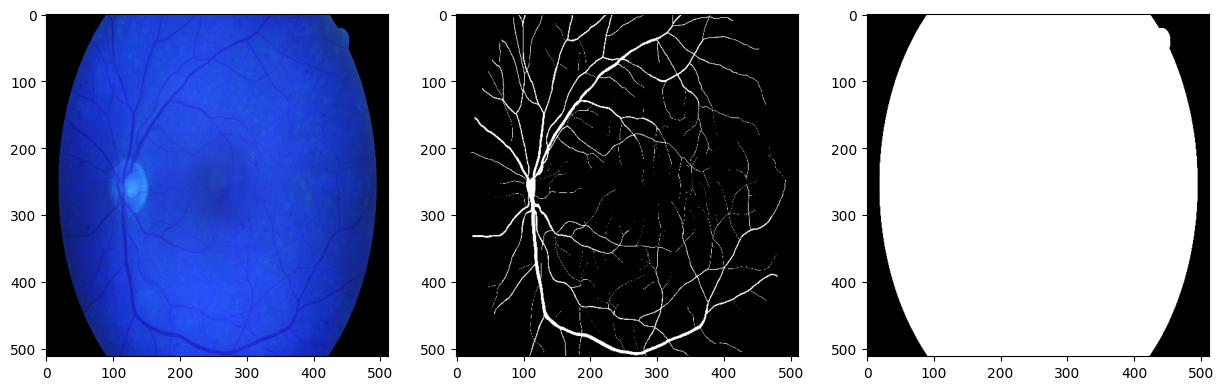

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(X[0], cmap='gray')
ax[1].imshow(y[0], cmap='gray')
ax[2].imshow(z[0] , cmap='gray')
plt.show()
# np.sum((y[0] < 255) & (y[0] > 0))

In [6]:
def sharpening(img):
    kernel = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])
    img_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img_sharp

In [7]:
def hist_equalization(img):
    ycrcb_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
    return equalized_img

In [8]:
def edge_detection(img, lvl=25):
    edges = cv2.Canny(img, lvl, lvl)
    return edges

In [9]:
def denoising(img, convert=False):
    if convert:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    denoised = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    return denoised

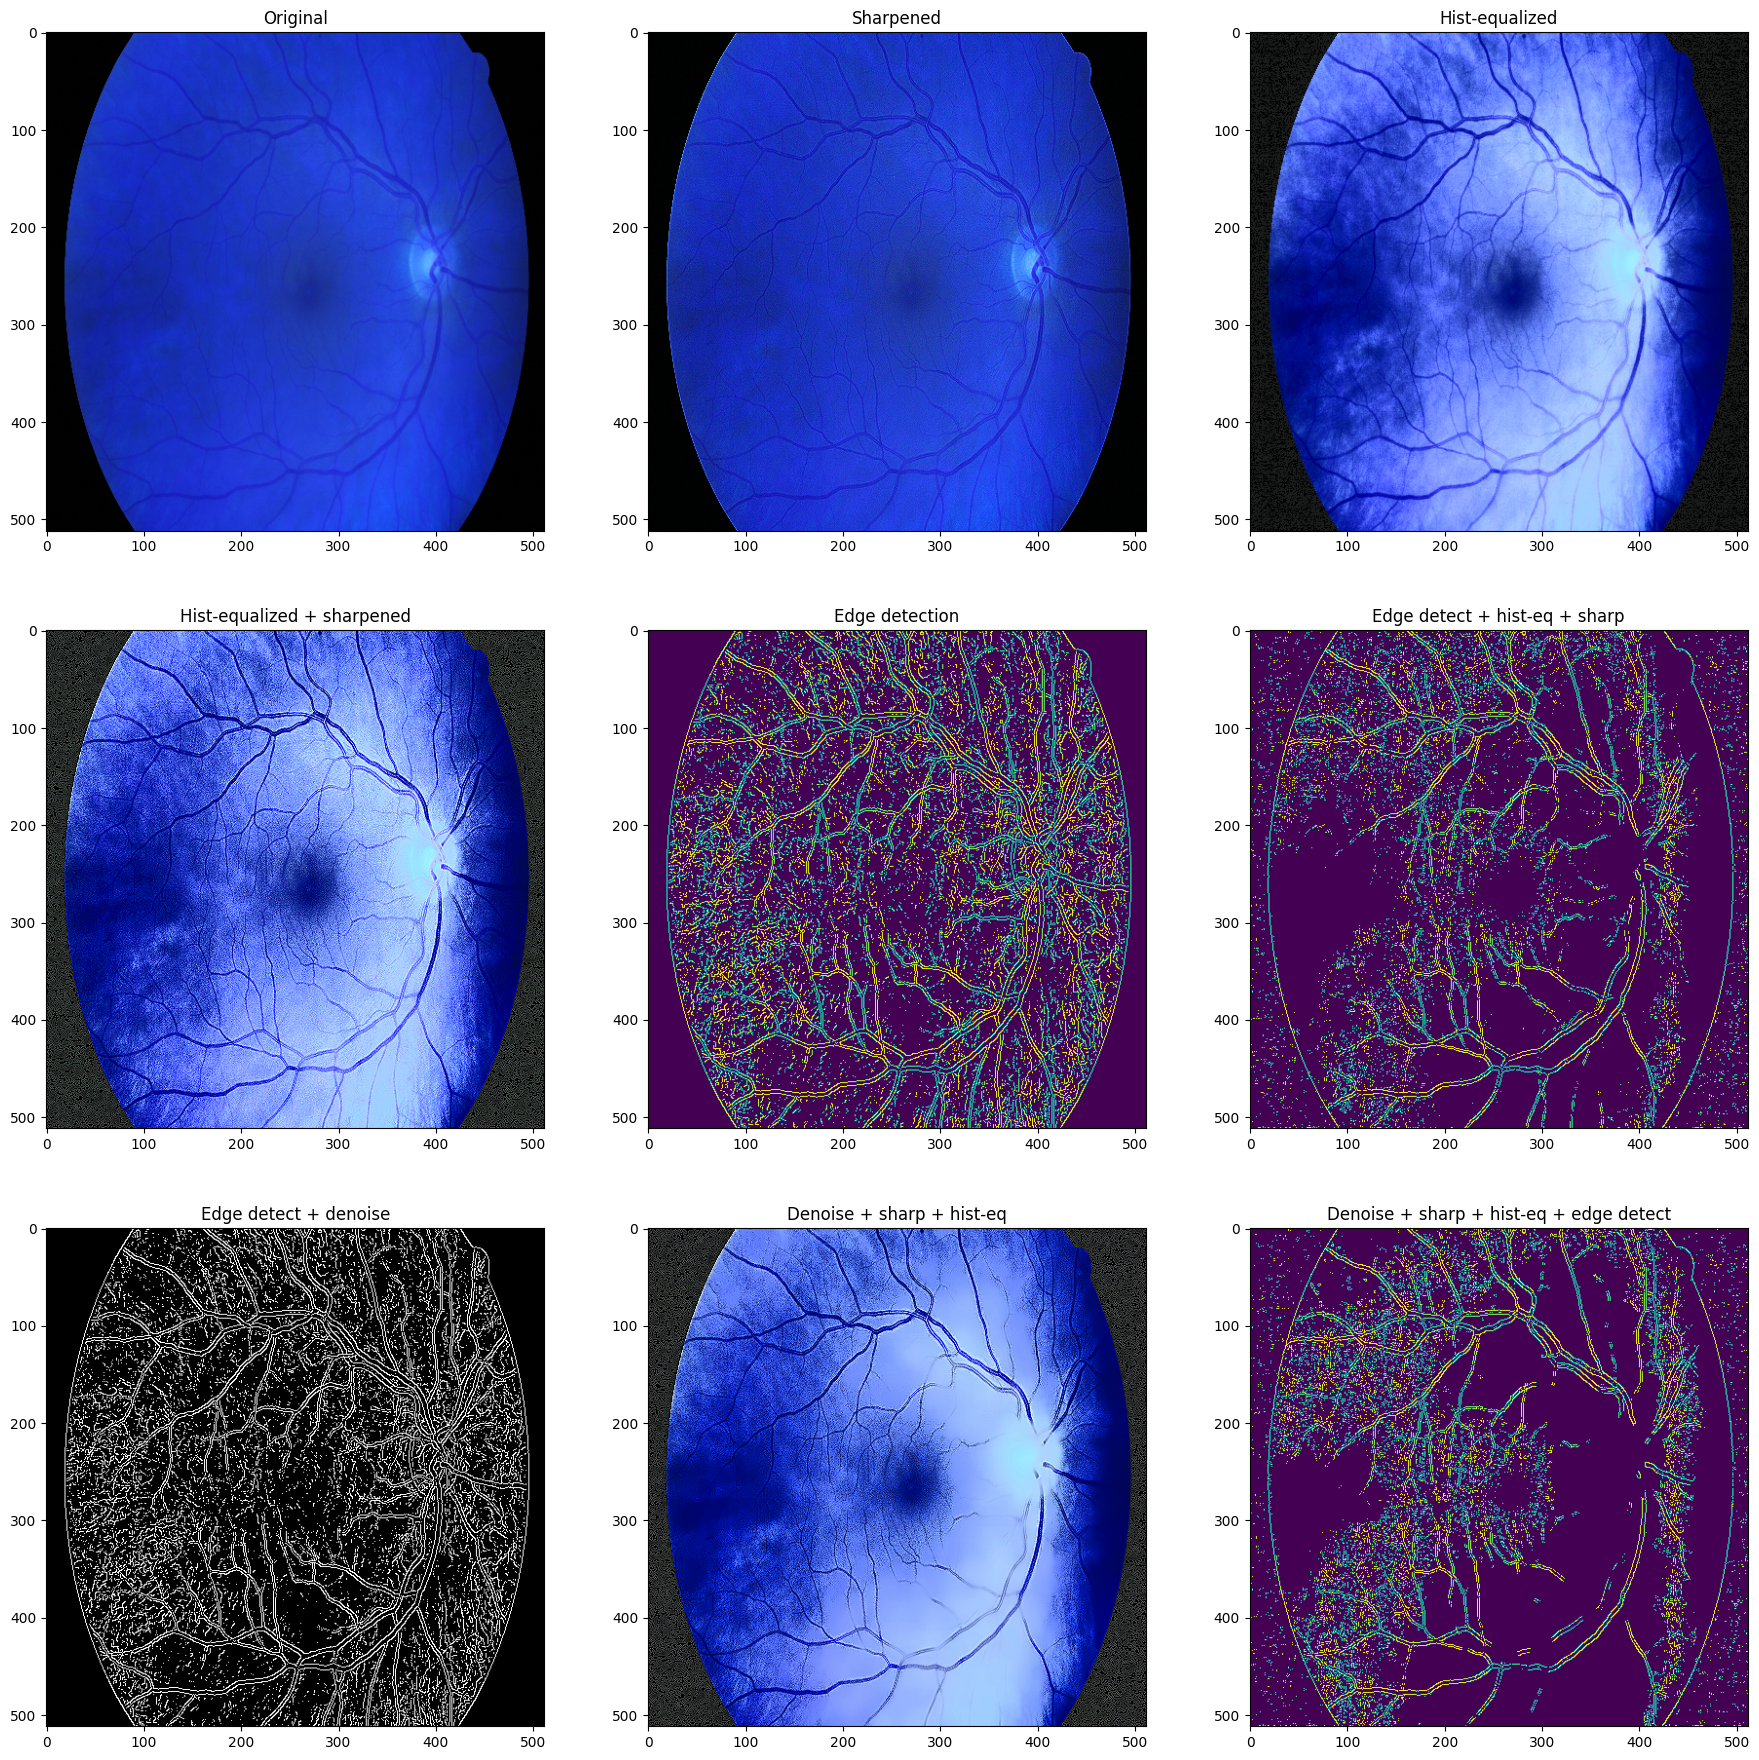

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(22,22))

ax[0,0].imshow(X[1])
ax[0,0].set_title('Original')

ax[0,1].imshow(sharpening(X[1]))
ax[0,1].set_title('Sharpened')

ax[0,2].imshow(hist_equalization(X[1]))
ax[0,2].set_title('Hist-equalized')

ax[1,0].imshow(sharpening(hist_equalization(X[1])))
ax[1,0].set_title('Hist-equalized + sharpened')

ax[1,1].imshow(edge_detection(X[1]))
ax[1,1].set_title('Edge detection')

ax[1,2].imshow(edge_detection(sharpening(hist_equalization(X[1])), lvl=330))
ax[1,2].set_title('Edge detect + hist-eq + sharp')

ax[2,0].imshow(denoising(edge_detection(X[1]), convert=True))
ax[2,0].set_title('Edge detect + denoise')

ax[2,1].imshow(denoising(sharpening(hist_equalization(X[1]))))
ax[2,1].set_title('Denoise + sharp + hist-eq')

ax[2,2].imshow(edge_detection(denoising(sharpening(hist_equalization(X[1]))), lvl=330))
ax[2,2].set_title('Denoise + sharp + hist-eq + edge detect')

plt.show()

## Deep Learning Approach

In [ ]:
# !pip install segmentation-models

In [11]:
import segmentation_models as sm
# if you get an errror: module 'keras.utils.generic_utils' has no attribute 'get_custom_objects'
# open keras.py and change all 'init_keras_custom_objects' to 'init_tfkeras_custom_objects'

Segmentation Models: using `keras` framework.


In [106]:
class PlotCallback(Callback):
    def __init__(self, val_generator, title, num_epochs=1):
        super(PlotCallback, self).__init__()
        self.val_generator = val_generator
        self.num_epochs = num_epochs
        self.title = title

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.num_epochs == 0:
            val_images, val_masks = next(iter(self.val_generator))
            predicted_masks = self.model.predict(val_images)
            
            fig, ax = plt.subplots(1, 3, figsize=(8, 4))
            
            ax[0].imshow(val_images[0][:,:,1])
            ax[0].set_title("Ground Truth")

            ax[1].imshow(val_masks[0])
            ax[1].set_title("Mask")

            ax[2].imshow(predicted_masks[0])
            ax[2].set_title("Predicted")

            fig.suptitle(self.title)
            fig.tight_layout()
            plt.show()
            

In [109]:
val_samples = 15 
batch_size = 2 

y = 255 - np.array(y)

X_train = np.array(X[val_samples:]) / 255
y_train = np.expand_dims(np.array(y[val_samples:]), 3)

X_val = np.array(X[:val_samples]) / 255
y_val = np.expand_dims(np.array(y[:val_samples]), 3)

y_train = y_train / 128
y_val = y_val / 128

y_train[y_train < 1] = 0
y_train[y_train > 1] = 1

y_val[y_val < 1] = 0
y_val[y_val > 1] = 1

# y_train = y_train.astype('int')
# y_val = y_val.astype('int')

train_datagen = ImageDataGenerator()
        #rotation_range=20,
        #zoom_range=0.2,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #horizontal_flip=True,
        #vertical_flip=True,
        #rescale=1./255)

val_datagen = ImageDataGenerator() # rescale=1./255

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

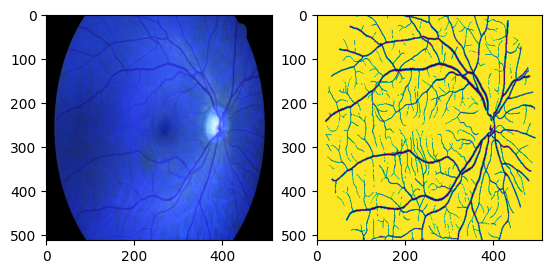

In [110]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(val_generator[0][0][0],cmap='gray')
ax[1].imshow(val_generator[0][1][0])
plt.show()

Epoch 1/20
15/15 [==============================] - 23s 1s/step - loss: 0.5211 - accuracy: 0.7914 - val_loss: 1.5779 - val_accuracy: 0.0781
Epoch 2/20
1/1 [==============================] - 2s 2s/step- loss: 0.4251 - accuracy: 0.88


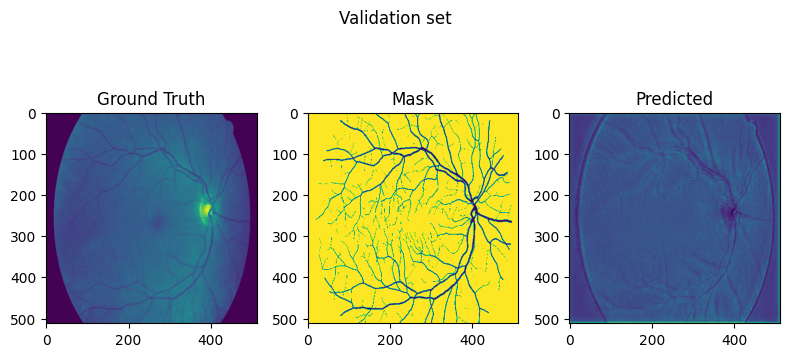

15/15 [==============================] - 20s 1s/step - loss: 0.4251 - accuracy: 0.8841 - val_loss: 1.4337 - val_accuracy: 0.0783
Epoch 3/20
15/15 [==============================] - 18s 1s/step - loss: 0.3684 - accuracy: 0.9157 - val_loss: 1.1455 - val_accuracy: 0.0834
Epoch 4/20
1/1 [==============================] - 0s 335ms/steposs: 0.3317 - accuracy: 0.93


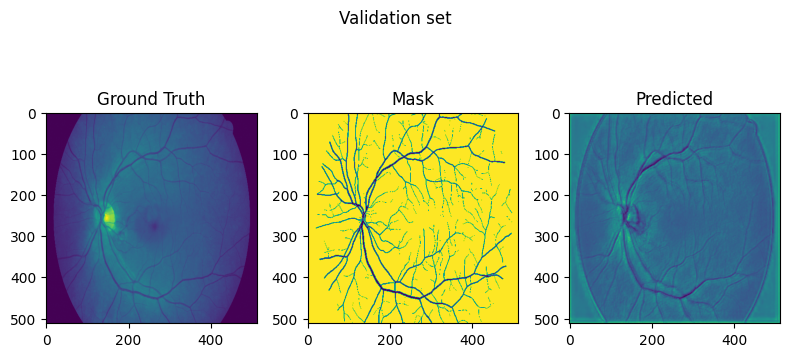

15/15 [==============================] - 19s 1s/step - loss: 0.3317 - accuracy: 0.9315 - val_loss: 0.9246 - val_accuracy: 0.1110
Epoch 5/20
15/15 [==============================] - 18s 1s/step - loss: 0.3001 - accuracy: 0.9413 - val_loss: 0.7637 - val_accuracy: 0.3229
Epoch 6/20
1/1 [==============================] - 0s 168ms/steposs: 0.2753 - accuracy: 0.94


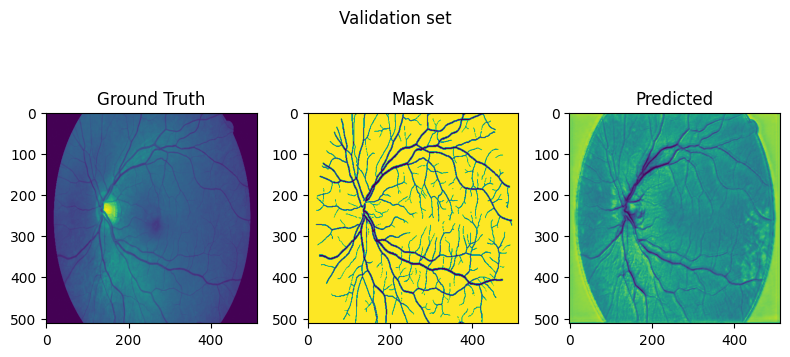

15/15 [==============================] - 19s 1s/step - loss: 0.2753 - accuracy: 0.9470 - val_loss: 0.6928 - val_accuracy: 0.3906
Epoch 7/20
15/15 [==============================] - 18s 1s/step - loss: 0.2537 - accuracy: 0.9508 - val_loss: 0.5578 - val_accuracy: 0.8134
Epoch 8/20
1/1 [==============================] - 0s 337ms/steposs: 0.2355 - accuracy: 0.95


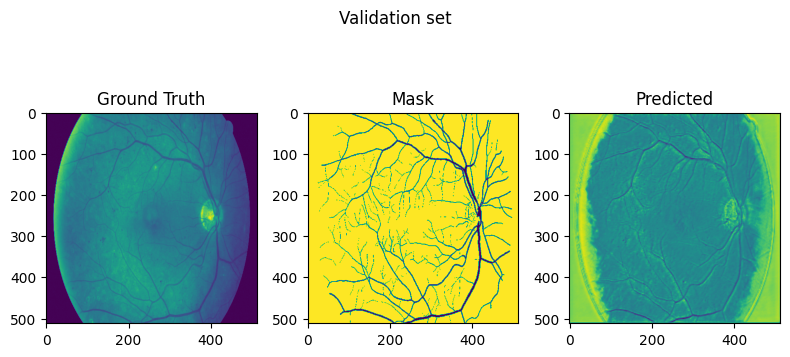

15/15 [==============================] - 19s 1s/step - loss: 0.2355 - accuracy: 0.9532 - val_loss: 0.6191 - val_accuracy: 0.8678
Epoch 9/20
15/15 [==============================] - 18s 1s/step - loss: 0.2198 - accuracy: 0.9549 - val_loss: 0.3736 - val_accuracy: 0.9195
Epoch 10/20
1/1 [==============================] - 0s 333ms/steposs: 0.2056 - accuracy: 0.95


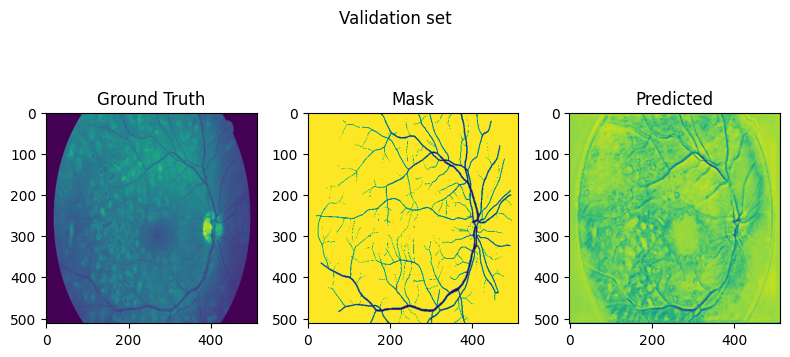

15/15 [==============================] - 19s 1s/step - loss: 0.2056 - accuracy: 0.9568 - val_loss: 0.4520 - val_accuracy: 0.9011
Epoch 11/20
15/15 [==============================] - 18s 1s/step - loss: 0.1946 - accuracy: 0.9576 - val_loss: 0.5790 - val_accuracy: 0.8525
Epoch 12/20
1/1 [==============================] - 0s 338ms/steposs: 0.1850 - accuracy: 0.95


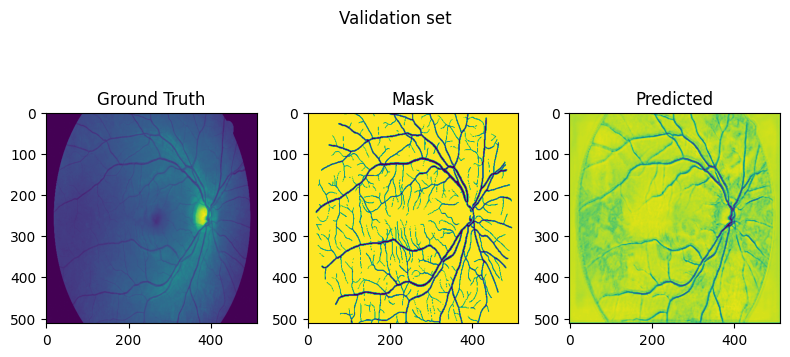

15/15 [==============================] - 19s 1s/step - loss: 0.1850 - accuracy: 0.9588 - val_loss: 0.3469 - val_accuracy: 0.8857
Epoch 13/20
15/15 [==============================] - 18s 1s/step - loss: 0.1772 - accuracy: 0.9598 - val_loss: 0.2649 - val_accuracy: 0.9308
Epoch 14/20
1/1 [==============================] - 0s 335ms/steposs: 0.1704 - accuracy: 0.96


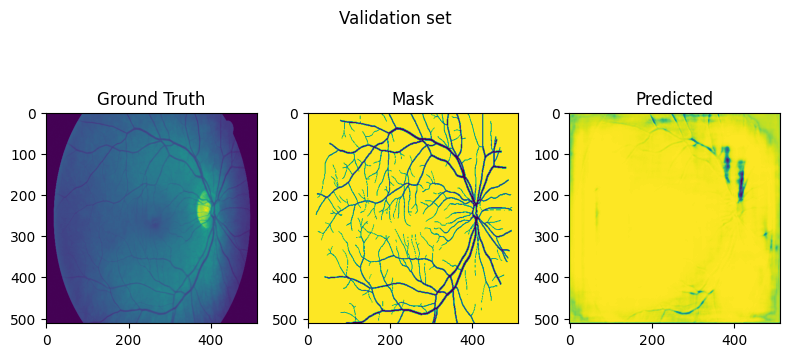

15/15 [==============================] - 19s 1s/step - loss: 0.1704 - accuracy: 0.9603 - val_loss: 0.2693 - val_accuracy: 0.9219
Epoch 15/20
15/15 [==============================] - 19s 1s/step - loss: 0.1645 - accuracy: 0.9609 - val_loss: 0.2489 - val_accuracy: 0.9341
Epoch 16/20
1/1 [==============================] - 0s 326ms/steposs: 0.1590 - accuracy: 0.96


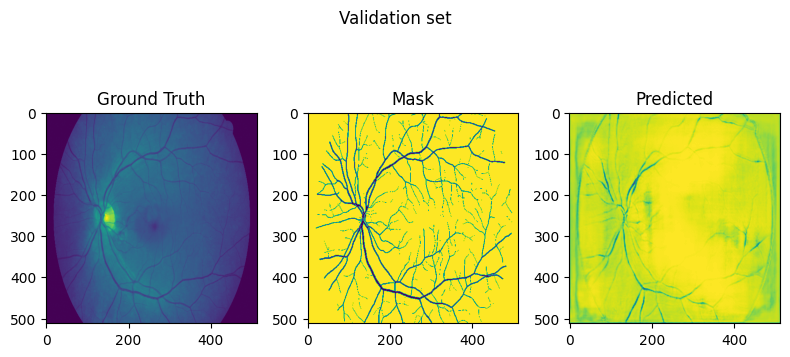

15/15 [==============================] - 19s 1s/step - loss: 0.1590 - accuracy: 0.9618 - val_loss: 0.2286 - val_accuracy: 0.9307
Epoch 17/20
15/15 [==============================] - 18s 1s/step - loss: 0.1539 - accuracy: 0.9624 - val_loss: 0.2767 - val_accuracy: 0.9123
Epoch 18/20
1/1 [==============================] - 0s 335ms/steposs: 0.1511 - accuracy: 0.96


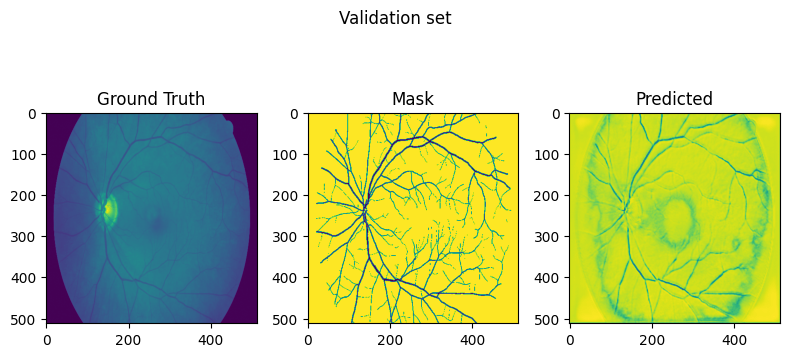

15/15 [==============================] - 19s 1s/step - loss: 0.1511 - accuracy: 0.9624 - val_loss: 0.2239 - val_accuracy: 0.9399
Epoch 19/20
15/15 [==============================] - 18s 1s/step - loss: 0.1469 - accuracy: 0.9628 - val_loss: 0.1995 - val_accuracy: 0.9402
Epoch 20/20
1/1 [==============================] - 0s 333ms/steposs: 0.1428 - accuracy: 0.96


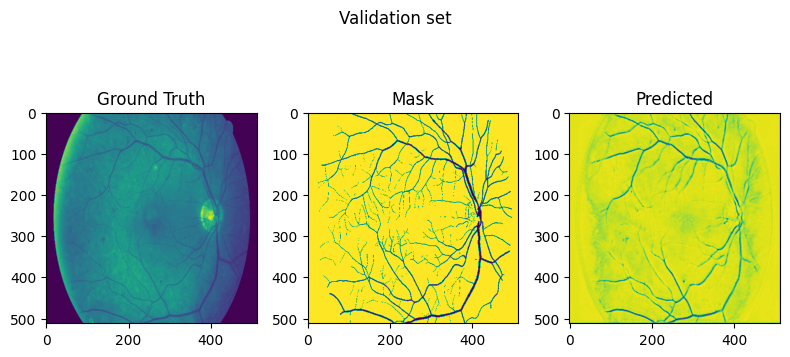

15/15 [==============================] - 20s 1s/step - loss: 0.1428 - accuracy: 0.9633 - val_loss: 0.1956 - val_accuracy: 0.9408


In [113]:
from keras.losses import BinaryCrossentropy
model = sm.Unet('efficientnetb0', classes=1, activation='sigmoid')
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[PlotCallback(val_generator, title='Validation set', num_epochs=2)],
              #PlotCallback(train_generator, title='Train set', num_epochs=1)],
    epochs=20
)

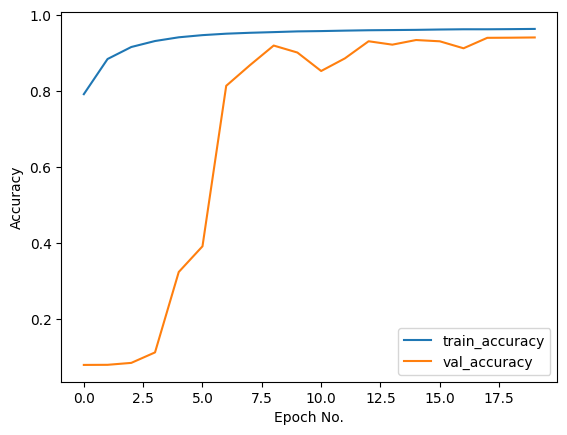

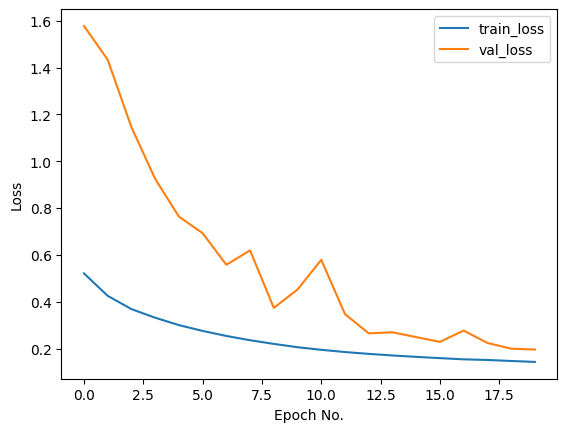

In [114]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch No.')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch No.')
plt.legend()
plt.show()

In [ ]:
# 90000 / 150 / 150 / 4
# 102400 / 160 / 160 / 4